# LANL EARTHQUAKE PROJECT

### background

This was a project we put together for the following kaggle competition: https://www.kaggle.com/c/LANL-Earthquake-Prediction

As we were past the deadline, we viewed it more as preparation for future kaggle competitions

## packages and parameters

In [1]:
import numpy as np 
import pandas as pd
import os
%matplotlib inline

import zipfile
import pickle
import random
from scipy import stats
from scipy import fftpack

from xgboost import XGBRegressor
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt # may remove later

from sklearn.model_selection import train_test_split
from pathlib import Path

import heapq

#### set project parameters

In [2]:
# edit
PROJECT_DIR = Path('/notebooks/storage/earthquake')

#### change `pwd` to `PROJECT_DIR`

In [3]:
os.chdir(PROJECT_DIR)

print(os.getcwd())
print(os.listdir())

/storage/earthquake
['test_samples.pickle', 'train.csv', 'leaked_samples_eng.pickle', 'consecutive_samples.pickle', 'submission.csv', 'model_xgb.pickle', 'refactor.ipynb', 'test_samples_eng.pickle', 'leaked_samples.pickle', 'model_4096_all.pickle', 'train.pickle', '.ipynb_checkpoints', 'test']


## download/unzip/load data from kaggle
- run once -> comment out
- ADD: NOTE ON WHAT HAPPENS IF IT IS RUN TWICE, REPLACEMENT OR COLLISION ????

In [ ]:
# %%time
# !kaggle competitions download LANL-Earthquake-Prediction

#### unzip kaggle files
NOTE: run once -> comment out

In [ ]:
# %%time

# train_zip='train.csv.zip'
# test_zip='test.zip'
# earthquake_dir='.'
# test_dir='./test'

# zip_ref=zipfile.ZipFile(train_zip,'r')
# zip_ref.extractall(earthquake_dir)
# zip_ref.close()

# zip_ref=zipfile.ZipFile(test_zip,'r')
# zip_ref.extractall(test_dir)
# zip_ref.close()

#### read train csv -> convert to dataframe -> pickle
NOTE: run once -> pickle `train` -> comment out

NOTE: this notebook makes heavy use of the `pickle` library, which allows us to save environment objects as files and pick up where we left off

In [ ]:
# %%time 

# train = pd.read_csv('./train.csv', dtype={"acoustic_data": np.int16, "time_to_failure": np.float32})

#### pickle `train` dataframe
- NOTE: run once then comment out
- CAUTION !!! code below overwrites `train`!!!

In [ ]:
# %%time

# with open('/notebooks/storage/earthquake/train.pickle','wb') as f:
#     pickle.dump(train,f,pickle.HIGHEST_PROTOCOL)

#### delete `train` dataframe from ram

In [ ]:
del train

#### load `train` dataframe

In [4]:
%%time

with open(PROJECT_DIR/'train.pickle','rb') as f:
    train = pickle.load(f)

train.tail()

CPU times: user 1.48 s, sys: 5.81 s, total: 7.29 s
Wall time: 12.5 s


## data

The general goal of the competition is to predict future earthquakes given seismograph data

The training data cointains a single sequence of 630M or so readings, each one indicating both a seismograph reading (`acoustic_data`) and time until the next earthquake (`time_to_failure`).

A picture is worth a thousand words, so below are som figures:

#### train data frame and summary stats

In [5]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [6]:
train.tail()

,acoustic_data,time_to_failure
629145475,7,9.759795
629145476,9,9.759795
629145477,10,9.759795
629145478,6,9.759795
629145479,5,9.759795


In [7]:
%%time

train.describe()

CPU times: user 40.7 s, sys: 18.4 s, total: 59.1 s
Wall time: 59 s


,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,4.477084e-01
std,1.073571e+01,2.612789e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173395e+00
max,5.444000e+03,1.610740e+01


In [8]:
train.shape

(629145480, 2)

In [6]:
# r = random.randint(1,620000000)
# interval = (train.loc[r-150000,'time_to_failure'] - train.loc[r,'time_to_failure'])/150000; interval

#hard-coded time in seconds between readings
interval = 2.553520600001017e-07

In [7]:
%%time

x_axis = np.arange(start=0,stop=train.shape[0],step=100)*interval

CPU times: user 6.82 ms, sys: 3.38 ms, total: 10.2 ms
Wall time: 8.28 ms


In [9]:
x_axis.shape

(629146,)

In [8]:
x_axis

array([0.00000000e+00, 2.55352060e-04, 5.10704120e-04, ...,
       1.60652961e+02, 1.60653216e+02, 1.60653472e+02])

#### a small subsection of `train`

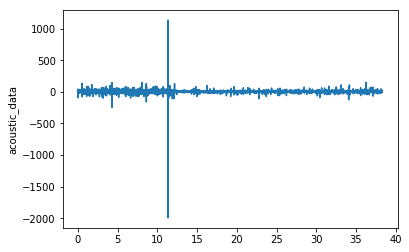

In [16]:
sns.lineplot(y=train['acoustic_data'][:15000000:100],x=x_axis[:150000])

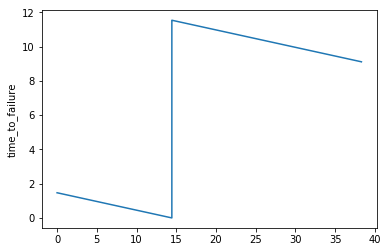

In [17]:
sns.lineplot(y=train['time_to_failure'][:15000000:100],x=x_axis[:150000])

NOTE: The test data, explained later, is around 2600 sequence each of length 150K, containing the same data points as in train: `acoustic_data` and `time_to_failure`

## generate consecutive samples

this function generates a dataframe of ~4200 samples (sampled csonsecutively, non-overlapping), using same format as test set

#### set `consecutive_sample` parameters

In [ ]:
# edit
CONS_FILENAME = 'consecutive_samples'

#leave as-is
cons_filename = PROJECT_DIR/str(CONS_FILENAME+'.pickle')

In [ ]:
def generateConsecutive(train):
    '''
    input: train dataframe (dim: #entries x 2 features: acoustic_data/time_to_failure)
    returns: dataframe with length/sample_length consecutive samples, each with:
        sequence = np.array(150k,) and time_to_failure = float
    '''
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(length//sample_length):
        
        start = i*sample_length
        end = (i+1)*sample_length
        
        samples += [[train['acoustic_data'].values[start:end],train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'time_to_failure'})
    
    return df

In [ ]:
%%time

consecutive_samples = generateConsecutive(train)

In [ ]:
consecutive_samples.tail()

 #### pickle `consecutive_samples`

NOTE: run once -> comment out

In [ ]:
# %%time

# with open(cons_filename,'wb') as f:
#     pickle.dump(consecutive_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `consecutive_samples` from ram

In [ ]:
del consecutive_samples

#### load pickled `consecutive_samples` from PROJECT_DIR

In [ ]:
%%time

with open(cons_filename,'rb') as f:
    consecutive_samples = pickle.load(f)

In [ ]:
consecutive_samples.tail()

## generate N random samples

this function generates a dataframe of N samples (sampled randomly, with replacement), using same format as test set

In [ ]:
# edit
RAND_FILENAME = 'random_samples'

#leave unchanged
rand_filename = PROJECT_DIR/str(RAND_FILENAME+'.pickle')

In [ ]:
def generateRandom(train,n):
    '''
    input: train dataframe (dim: #entries x 2 features: acoustic_data/time_to_failure)
    returns: dataframe with n random samples, each with:
        sequence = np.array(150k,) and time_to_failure = float
    '''
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(n):
        
        start = random.randint(0,max_start)
        end = start + sample_length
        
        samples += [[np.array(train['acoustic_data'].values[start:end]),train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'time_to_failure'})
    
    return df

In [ ]:
%%time

random_samples = generateRandom(train,1000)

In [ ]:
random_samples.tail()

 #### pickle `random_samples`

NOTE: run once -> comment out

In [ ]:
%%time

with open(rand_filename,'wb') as f:
    pickle.dump(random_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `random_samples` from ram

In [ ]:
del random_samples

#### load pickled `consecutive_samples` from `PROJECT_DIR`

In [ ]:
%%time

with open(rand_filename,'rb') as f:
    random_samples = pickle.load(f)

In [ ]:
random_samples.tail()

## Generate leaked samples
The sampling function is unintuitive:

it samples the train data in a non-uniform way such that train data is better aligned with test

we found the test mean by averaging our score of multiple trials of submitting guesses of 0 to test suite; the mean-absolute error would be the mean `time_to_failure`

In [ ]:
# edit
LEAKED_FILENAME = 'leaked_samples'
N_LEAKED_SAMPLES = 10

#leave unchanged
leaked_filename = PROJECT_DIR/str(LEAKED_FILENAME+'.pickle')

In [ ]:
# earthquake times
eq0 = (0,5656574)
eq3 = (104677355,138772454)
eq5 = (187641819,218652631)
eq6 = (218652629,245829586)
eq8 = (307838916,338276288)
eq12 = (461811622,495800226)
eq13 = (495800224,528777116)
eq16 = (621985672,629145480)

nogo = [eq0,eq16]
nogo1 = nogo + [eq3,eq5,eq6]
nogo2 = nogo + [eq3,eq8,eq12,eq13]
nogo3 = nogo + [eq6,eq8,eq13]
nogo4 = nogo + [eq6,eq8,eq12]

In [ ]:
def is_valid(start,end,nogo_list):
    
    valid = True
    
    for a,b in nogo_list:
        
        if start>a and start<b:
            valid = False
        if end>a and end<b:
            valid = False
        
    return valid
        
    

In [ ]:
def generateLeaked(train,n,nogo_list):
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(n):
        
        start = random.randint(0,max_start)
        end = start + sample_length
        
        while not is_valid(start,end,nogo_list):
            start = random.randint(0,max_start)
            end = start + sample_length
        
        samples += [[np.array(train['acoustic_data'].values[start:end]),train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'time_to_failure'})
    
    return df

In [ ]:
%%time

leaked_samples_list = []

nogos = [nogo1,nogo2,nogo3,nogo4]

for nogo in nogos:

    current_sample = generateLeaked(train,N_LEAKED_SAMPLES,nogo)
    
    leaked_samples_list += [current_sample]

In [ ]:
leaked_samples_list[3].tail()

In [ ]:
leaked_samples = pd.concat(leaked_samples_list, axis=0)
leaked_samples = leaked_samples.reset_index()
leaked_samples = leaked_samples.drop(labels=['index'],axis=1)

In [ ]:
leaked_samples.tail()

In [ ]:
leaked_samples.describe()

 #### pickle `leaked_samples`

NOTE: run once -> comment out

In [ ]:
# %%time

# with open(leaked_filename,'wb') as f:
#     pickle.dump(leaked_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `leaked_samples` from ram

In [ ]:
del leaked_samples

#### load pickled `leaked_samples` from `PROJECT_DIR`

In [ ]:
%%time

with open(leaked_filename,'rb') as f:
    leaked_samples = pickle.load(f)

In [ ]:
leaked_samples.tail()

## full sequence features
this function adds non-FFT features to samples dataframe

In [ ]:
def generateFullFeatures(samples_df):
    
    #defining x as matrix of sequence data
    x = []
    for index,row in samples_df.iterrows():
        x += [samples_df.loc[index,'sequence']]    
    x = np.stack(x)
    x_abs = np.absolute(x)
    
    length=150000
    
    #non-abs
    samples_df['mean'] = np.mean(x,axis=1)
    samples_df['median'] = np.median(x,axis=1)
    samples_df['std'] = np.std(x,axis=1)
    
    samples_df['kurtosis'] = stats.kurtosis(x,axis=1)   
    samples_df['m2'] = stats.moment(x,axis=1,moment=2)
    samples_df['m3'] = stats.moment(x,axis=1,moment=3)
    samples_df['skew'] = stats.skew(x,axis=1)
    samples_df['variation'] = stats.variation(x,axis=1)
    samples_df['sem'] = stats.sem(x,axis=1)

    samples_df['iqr25_75'] = stats.iqr(x,axis=1,rng=(25,75))
    samples_df['iqr10_90'] = stats.iqr(x,axis=1,rng=(10,90))
    samples_df['iqr5_95'] = stats.iqr(x,axis=1,rng=(5,95))
    samples_df['iqr1_99'] = stats.iqr(x,axis=1,rng=(1,99))
    
    
    #abs
    samples_df['mean_abs'] = np.mean(x_abs,axis=1)
    samples_df['median_abs'] = np.median(x_abs,axis=1)
    samples_df['std_abs'] = np.std(x_abs,axis=1)
    
    samples_df['kurtosis_abs'] = stats.kurtosis(x_abs,axis=1)   
    samples_df['m2_abs'] = stats.moment(x_abs,axis=1,moment=2)
    samples_df['m3_abs'] = stats.moment(x_abs,axis=1,moment=3)
    samples_df['skew_abs'] = stats.skew(x_abs,axis=1)
    samples_df['variation_abs'] = stats.variation(x_abs,axis=1)
    samples_df['sem_abs'] = stats.sem(x_abs,axis=1)

    
    samples_df['iqr25_75_abs'] = stats.iqr(x_abs,axis=1,rng=(25,75))
    samples_df['iqr10_90_abs'] = stats.iqr(x_abs,axis=1,rng=(10,90))
    samples_df['iqr5_95_abs'] = stats.iqr(x_abs,axis=1,rng=(5,95))
    samples_df['iqr1_99_abs'] = stats.iqr(x_abs,axis=1,rng=(1,99))
    
    
    #slices
    slices_list = [2,4]
    
    for slices in slices_list:

        for i in range(slices):

            suffix = '_'+str(slices)+'_'+str(i+1)

            #create same as above, but for first half and second half
            
            x_slice = x[:,i*(length//slices):(i+1)*(length//slices)]
            x_abs_slice = np.absolute(x_slice)

            #non-abs
            samples_df['mean'+suffix] = np.mean(x_slice,axis=1)
            samples_df['median'+suffix] = np.median(x_slice,axis=1)
            samples_df['std'+suffix] = np.std(x_slice,axis=1)

            samples_df['kurtosis'+suffix] = stats.kurtosis(x_slice,axis=1)
            samples_df['m2'+suffix] = stats.moment(x_slice,axis=1,moment=2)
            samples_df['m3'+suffix] = stats.moment(x_slice,axis=1,moment=3)
            samples_df['skew'+suffix] = stats.skew(x_slice,axis=1)
            samples_df['variation'+suffix] = stats.variation(x_slice,axis=1)
            samples_df['sem'+suffix] = stats.sem(x_slice,axis=1)

            samples_df['iqr25_75'+suffix] = stats.iqr(x_slice,axis=1,rng=(25,75))
            samples_df['iqr10_90'+suffix] = stats.iqr(x_slice,axis=1,rng=(10,90))
            samples_df['iqr5_95'+suffix] = stats.iqr(x_slice,axis=1,rng=(5,95))
            samples_df['iqr1_99'+suffix] = stats.iqr(x_slice,axis=1,rng=(1,99))


            #abs
            samples_df['mean_abs'+suffix] = np.mean(x_abs_slice,axis=1)
            samples_df['median_abs'+suffix] = np.median(x_abs_slice,axis=1)
            samples_df['std_abs'+suffix] = np.std(x_abs_slice,axis=1)

            samples_df['kurtosis_abs'+suffix] = stats.kurtosis(x_abs_slice,axis=1)
            samples_df['m2_abs'+suffix] = stats.moment(x_abs_slice,axis=1,moment=2)
            samples_df['m3_abs'+suffix] = stats.moment(x_abs_slice,axis=1,moment=3)
            samples_df['skew_abs'+suffix] = stats.skew(x_abs_slice,axis=1)
            samples_df['variation_abs'+suffix] = stats.variation(x_abs_slice,axis=1)
            samples_df['sem_abs'+suffix] = stats.sem(x_abs_slice,axis=1)


            samples_df['iqr25_75_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(25,75))
            samples_df['iqr10_90_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(10,90))
            samples_df['iqr5_95_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(5,95))
            samples_df['iqr1_99_abs'+suffix] = stats.iqr(x_abs_slice,axis=1,rng=(1,99))            
            

the function below adds the following FFT features to the chosen engineered dataframe:

top frequency in 5 different bands (identified through dataviz), as well as its corresponding amplitude

In [ ]:
def FFTSingle(index,sequence,samples_df):
    
    x_realfft = np.real(fftpack.fft(sequence))
    
    band1 = x_realfft[600:900]
    band2 = x_realfft[1100:1450]
    band3 = x_realfft[1450:1900]
    band4 = x_realfft[1950:2800]
    band5 = x_realfft[33000:42000]
    
    samples_df.loc[index,'band1_alt'] = np.max(band1)
    samples_df.loc[index,'band1_freq'] = np.argmax(band1)
    samples_df.loc[index,'band2_alt'] = np.max(band2)
    samples_df.loc[index,'band2_freq'] = np.argmax(band2)
    samples_df.loc[index,'band3_alt'] = np.max(band3)
    samples_df.loc[index,'band3_freq'] = np.argmax(band3)
    samples_df.loc[index,'band4_alt'] = np.max(band4)
    samples_df.loc[index,'band4_freq'] = np.argmax(band4)
    samples_df.loc[index,'band5_alt'] = np.max(band5)
    samples_df.loc[index,'band5_freq'] = np.argmax(band5)
    
def generateFFTFeatures(samples_df):
    
    for index, row in samples_df.iterrows():
        
        FFTSingle(index,row['sequence'],samples_df)

## generate features for a sample

here, we define which samples we want to load/generate features for, and then generate those features

In [ ]:
#edit
eng_samples = leaked_samples

In [ ]:
#edit
eng_samples_name = 'leaked_samples'

#leave as-is
eng_samples_filename = PROJECT_DIR/str(eng_samples_name+'_eng.pickle')

In [ ]:
%%time

generateFullFeatures(eng_samples)
generateFFTFeatures(eng_samples)

In [ ]:
eng_samples.tail()

 #### pickle `eng_samples`

NOTE: run once -> comment out

In [ ]:
# %%time

# with open(eng_samples_filename,'wb') as f:
#     pickle.dump(eng_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `eng_samples` from ram

In [ ]:
del eng_samples

#### load pickled `eng_samples` from PROJECT_DIR

In [ ]:
%%time

with open(eng_samples_filename,'rb') as f:
    eng_samples = pickle.load(f)

In [ ]:
eng_samples.tail()

## visualize data

below we play around with some useful plotting libraries to better visualize key features

In [ ]:
eng_samples.band3_freq.describe()

In [ ]:
eng_samples.plot(x='iqr1_99_abs',y='time_to_failure',kind='scatter',logx=True)

In [ ]:
eng_samples.plot.hexbin(x='mean',y='time_to_failure',gridsize=10)

In [ ]:
sns.kdeplot(eng_samples.time_to_failure,eng_samples.band5_freq)

In [ ]:
sns.kdeplot(eng_samples.band5_freq)

In [ ]:
sns.kdeplot(eng_samples.time_to_failure)

In [ ]:
sns.pairplot(eng_samples[['time_to_failure','band1_freq','band2_freq','band3_freq','band4_freq','band5_freq']])

In [ ]:
sns.pairplot(eng_samples[['time_to_failure','band1_alt','band2_alt','band3_alt','band4_alt','band5_alt']])

In [ ]:
sns.jointplot(x='band2_alt',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log').annotate(stats.pearsonr, fontsize=10)

In [ ]:
sns.jointplot(x='band3_alt',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log')

In [ ]:
sns.jointplot(x='band4_alt',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log')

In [ ]:
sns.jointplot(x='band2_freq',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,yscale='log')

In [ ]:
sns.jointplot(x='iqr10_90',y='time_to_failure',data=eng_samples,kind='hex',gridsize=100,xscale='log',yscale='log')

In [ ]:
sns.jointplot(x='iqr5_95',y='time_to_failure',data=eng_samples,kind='hex',gridsize=25,xscale='log',yscale='log')

## Drop unwanted columns from sample

In [ ]:
# column_to_drop = []
# eng_samples.drop(labels=columns_to_drop,axis=1)

## split data into train/validation

we use sklearn's `train_test_split`, which allows us to adjust split test/train ratio, random state, shuffle, and other features out of the box

In [ ]:
X = eng_samples.drop(labels=['time_to_failure','sequence'],axis=1)
Y = eng_samples['time_to_failure']

x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=.1,random_state=0,shuffle=False)

In [ ]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

## XGBoost

we decided on using xgboost over a sequential model

intuitively, the test_sample length of 150k amounted to a time interval of ~.04seconds, which we felt was a small enough time frame to treat the entire sample a single input

our experiments using a gru proved this intuition correct

In [ ]:
n_estimators = 10000
learning_rate = .005
n_jobs = 8

early_stopping_rounds = 10
eval_set = [(x_val,y_val)]
verbose = True

In [ ]:
%%time

model = XGBRegressor(
    n_estimators = n_estimators, 
    learning_rate = learning_rate, 
    n_job = n_jobs
)

model.fit(x_train,y_train,
              early_stopping_rounds= early_stopping_rounds,
              eval_set = eval_set,
              eval_metric = 'mae',
              verbose = verbose
             )

from sklearn.metrics import mean_absolute_error


predictions = model.predict(x_val)
print('mae : '+str(mean_absolute_error(predictions,y_val)))

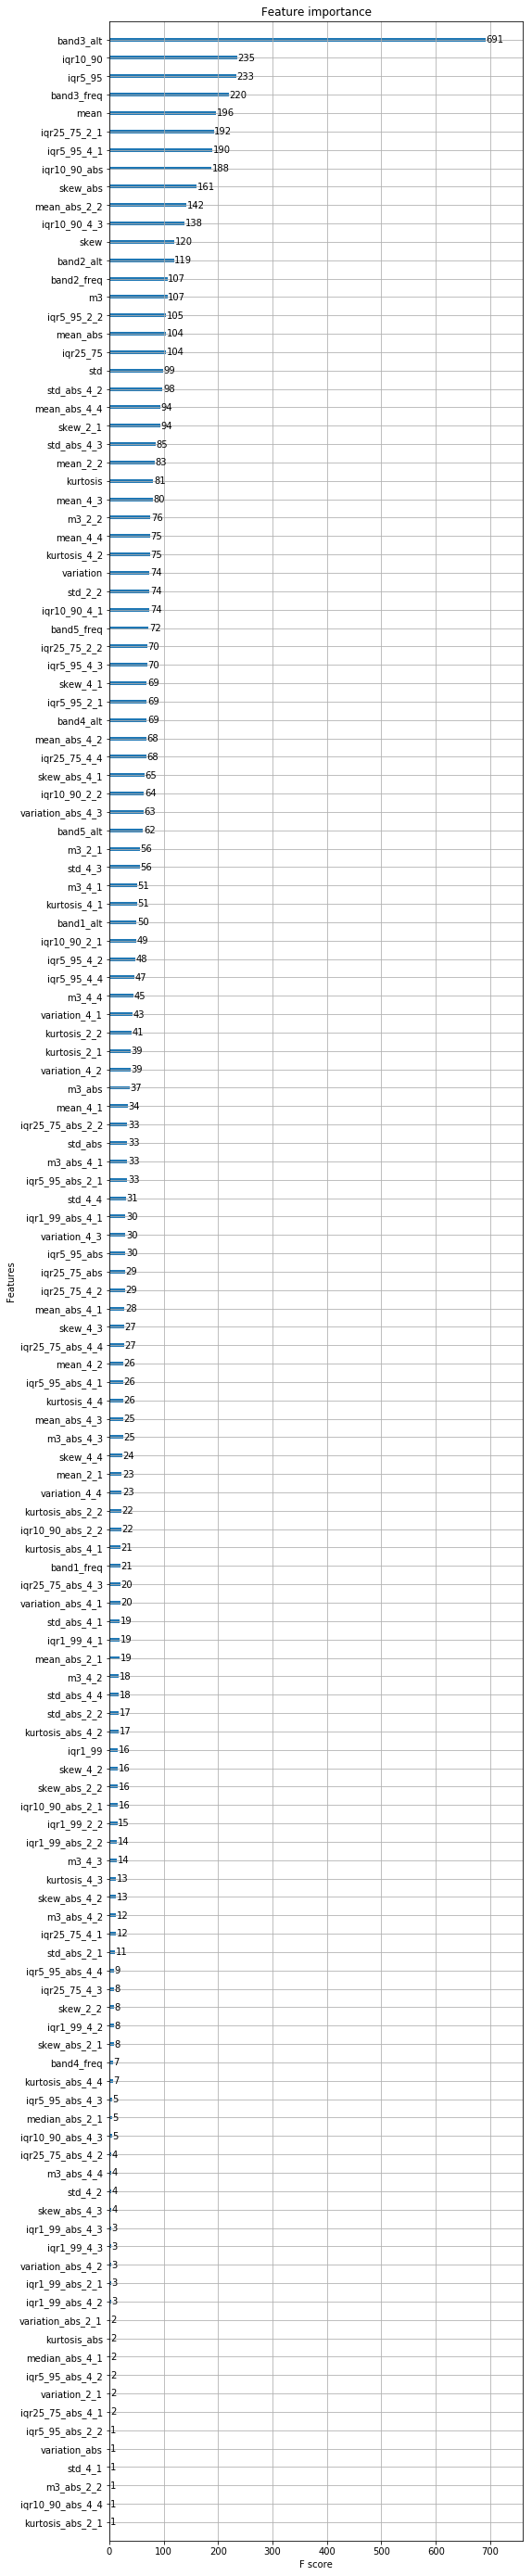

In [21]:
fig, ax = plt.subplots(figsize=(8, 50))
xgboost.plot_importance(model, ax=ax)

#### pickle `model`

In [19]:
# edit
MODEL_NAME = 'model_4096_all'

#leave as-is
model_filename = PROJECT_DIR/str(MODEL_NAME+'.pickle')

In [ ]:
# %%time

# with open(model_filename,'wb') as f:
#     pickle.dump(model,f,pickle.HIGHEST_PROTOCOL)

#### delete `model` from environment

In [ ]:
del model

#### load pickled `model`

In [20]:
%%time

with open(model_filename,'rb') as f:
    model = pickle.load(f)

[03:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2.95 ms, sys: 46.6 ms, total: 49.6 ms
Wall time: 127 ms


## create submission
as the test samples are each stored in a separate `.csv` file in the test folder, we first need to build a samples dataframe similar to the ones we encountered above, by looping through all files test files
#### start by creating a dataframe identical in format to consecutive/random samples above

In [ ]:
# edit
TEST_SAMPLES_NAME = 'test_samples'

# leave as-is
test_samples_filename = PROJECT_DIR/str(TEST_SAMPLES_NAME+'.pickle')

In [ ]:
%%time

os.chdir(PROJECT_DIR/'test')
    
test_samples = pd.DataFrame(columns=['sequence','time_to_failure']) #change to 'time_to_failure'

for i in range(len(os.listdir())):
    
    test_file = os.listdir()[i]
    
    temp_df = pd.read_csv('./'+test_file,engine='python')
        
    test_samples.loc[i,'sequence'] = np.array(temp_df['acoustic_data'].values[:])

test_samples.tail()

#### pickle `test_samples`

In [ ]:
# %%time

# with open(test_samples_filename,'wb') as f:
#     pickle.dump(test_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `test_samples` from environment

In [ ]:
del test_samples

#### load `test_samples`

In [ ]:
%%time

with open(test_samples_filename,'rb') as f:
    test_samples = pickle.load(f)

## generate features
now, with the test samples dataframe, we are ready to generate features

In [ ]:
%%time

generateFullFeatures(test_samples)
generateFFTFeatures(test_samples)

In [ ]:
%%time

test_samples.tail()

In [ ]:
test_samples.shape

#### pickle `test_samples_eng`

In [ ]:
%%time

with open(PROJECT_DIR/str(TEST_SAMPLES_NAME+'_eng.pickle'),'wb') as f:
    pickle.dump(test_samples,f,pickle.HIGHEST_PROTOCOL)

#### delete `test_samples_eng` from environment

In [ ]:
del test_samples

#### load `test_samples_eng`

In [ ]:
%%time

with open(PROJECT_DIR/str(TEST_SAMPLES_NAME+'_eng.pickle'),'rb') as f:
    test_samples = pickle.load(f)

In [ ]:
test_samples.tail()

In [ ]:
test_samples.shape

## make predictions/submit
This code will create a `submission.csv` file, that can be submitted to kaggle using the command line api, or website

In [ ]:
test_x = test_samples.drop(columns=['sequence','time_to_failure'])

y_pred = model.predict(test_x)

y_pred.shape

In [ ]:
submission_df = pd.DataFrame(columns=['seg_id','time_to_failure'])

submission_df['seg_id'] = pd.Series([i[:-4] for i in os.listdir(PROJECT_DIR/'test') if i[-4:]=='.csv'])
submission_df.shape

In [ ]:
submission_df['time_to_failure'] = y_pred

submission_df.to_csv(PROJECT_DIR/'submission.csv',index=False)

In [ ]:
submission_df.tail()